In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from lib.calmapLib import calmap, create_input
from datetime import datetime, timedelta

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('sgym_ship.csv', encoding = 'Shift-JIS')
df.columns = ['date','qty']
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()
df.head()

,qty
date,
2018-04-04,41296.0
2018-04-05,38153.0
2018-04-06,33987.0
2018-04-07,9665.0
2018-04-08,0.0


In [ ]:
df.plot(style=".",figsize=(20,8), color=color_pal[0])

In [ ]:
df.describe()

# Analysis

In [3]:
def feature_crt(df):
    """
    Create date features using dataframe with date index
    """
    df = df.copy()
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["dow"] = df.index.dayofweek
    df["doy"] = df.index.dayofyear
    
    #CUSTOM CODE FOR ADDING HOLIDAYS AS FEATURE (SEEMED TO ACTUALLY MADE PREDICTION WORSE)
#     holidays = pd.read_csv("holidays.csv")
#     holidays["hld_flg"] = 1
#     holidays = holidays.drop("Year", axis=1).set_index("Date")
    
#     df = df.merge(holidays, how="left", left_index=True, right_index=True)
#     df["hld_flg"] = df["hld_flg"].fillna(0)

    return df
df_proc = feature_crt(df)

In [ ]:
grouped = df_proc.groupby(["year","month"]).qty.sum()

fig, axes = plt.subplots(5,1,figsize=(10,8),sharex=True)

for ax, yr in zip(axes, df_proc["year"].unique()):
    ax.plot(grouped[yr], label=f"{yr}")
    ax.set_xticks(range(1,13))
    ax.set_xticklabels([i+1 for i in range(12)])
    ax.legend()

plt.show()

Looking at the above graph, we can see that there is a common pattern of a peak in March and June, followed by another uptick in September.

In [ ]:
# group_by_day = df_proc.groupby("day").qty.mean()
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, data=df_proc, x="day",y="qty")
plt.show()

There seems to be a pattern of higher demand at the beginning and end of the month

In [ ]:
group_by_dow = df_proc.groupby("dow").qty.mean()

fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(group_by_dow, color=color_pal[2])
sns.boxplot(ax=ax, data=df_proc, x="dow",y="qty")
ax.set_xticks(range(7))
ax.set_xticklabels(["mon","tue","wed","thu","fri","sat","sun"])
ax.set_title("Average demand by day of week")
plt.show()

Looking at average demand by day of week, we see that demand is usually highest at week beginning and lower towards the weekend

In [ ]:
grouped.plot(figsize=(15,5))

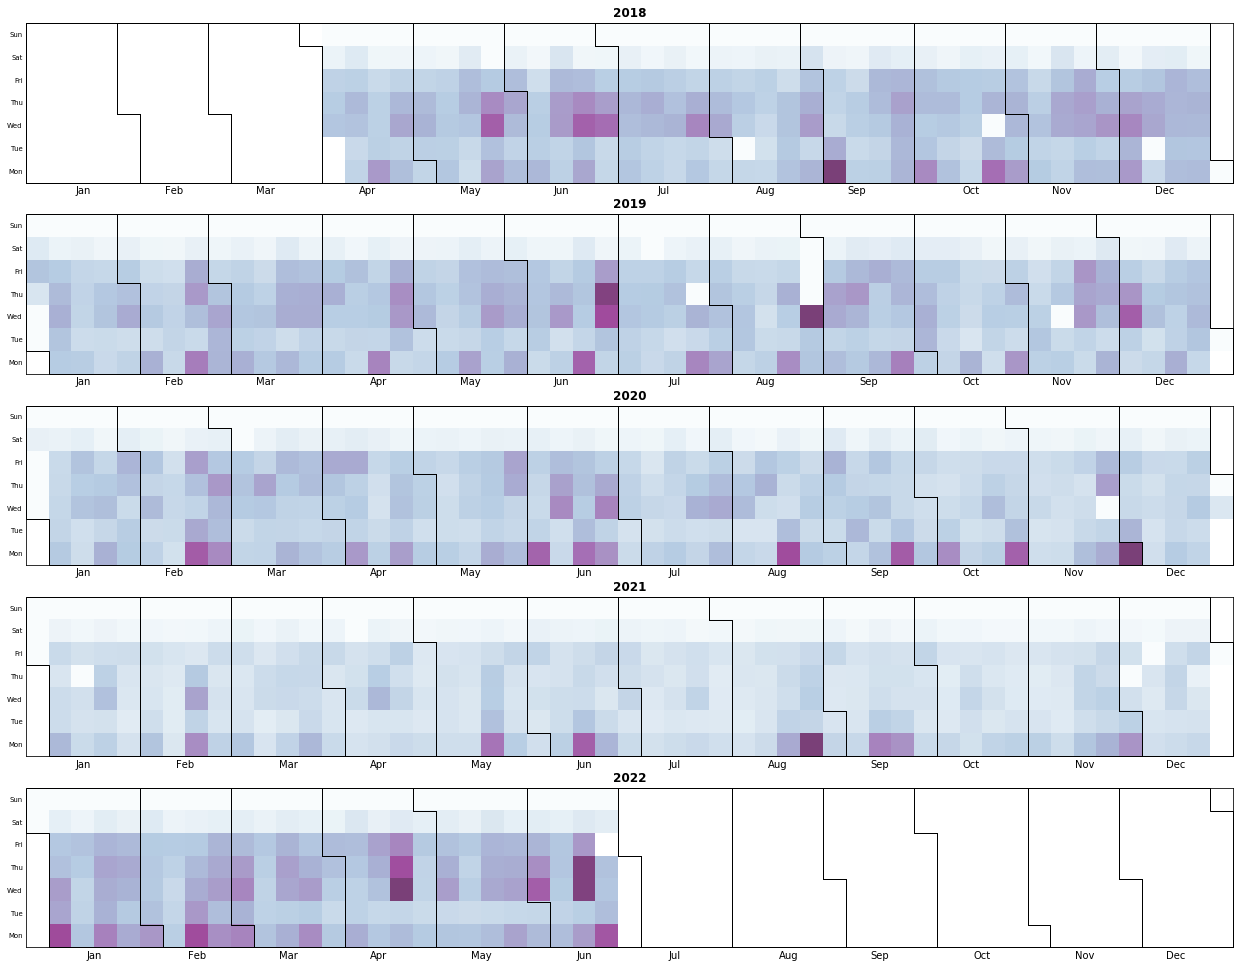

In [6]:
year = 2018
fig, axes = plt.subplots(5,1,figsize=(30,17))
for i in range(5):
    inp_raw = df_proc[df_proc["year"]==year].qty.copy()
    inp = create_input(inp_raw,year)
    calmap(axes[i], year, inp, col_map='BuPu')
    year+=1

# Train Test Split

In [ ]:
# Create train and test data, keeping 1 month of data for holdout
holdout_idx = "2022-06-01"
train = df.loc[df.index < "2021-07-01"]
test = df.loc[(df.index >= "2021-07-01") & (df.index < holdout_idx)]
holdout = df.loc[df.index >= holdout_idx]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train, label="train")
ax.plot(test, label="test")
ax.axvline(pd.to_datetime('2021-07-01'), color="black", ls="--")
ax.set_title("Train/Test Split")
plt.legend()
plt.show()

### Create features

In [ ]:
train = feature_crt(train)
test = feature_crt(test)

FEATURES = [col for col in train if col != "qty"]
TARGET = "qty"

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
holdout = feature_crt(holdout)
X_holdout = holdout[FEATURES]
y_holdout = holdout[TARGET]

# Model Creation

In [ ]:
class XGBRegressorExtended(xgb.XGBRegressor):
    """
    Custom Regressor class for forecasting values
    """
    def predict_transform(self, xtest):
        yt = self.predict(xtest)
        yt[yt<0] = 0
        return yt

In [ ]:
# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg = XGBRegressorExtended(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

In [ ]:
feat_imp = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
feat_imp.sort_values('importance').plot(kind='barh', title="Feature Importance")
plt.show()

# Predict on Test

In [ ]:
# test['prediction'] = reg.predict_transform(X_test)
holdout['prediction'] = reg.predict_transform(X_holdout)
# test['prediction'] = reg.predict(X_test)
if "prediction" in df_proc.columns:
    df_proc.drop("prediction", axis=1, inplace=True)
df_proc = df_proc.merge(holdout[['prediction']], how="left",left_index=True,right_index=True) #2 brackets -> dataframe instead of series

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_proc[["qty"]], label="Truth")
ax.plot(df_proc[["prediction"]],label="Prediction")
ax.set_title("Truth vs Prediction")
plt.show()

In [ ]:
#Check for 1 month
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_proc.loc[(df_proc["year"]==2022) & (df_proc["month"]==6)].qty, label="Truth")
ax.plot(df_proc.loc[(df_proc["year"]==2022) & (df_proc["month"]==6)].prediction,marker="o",label="Prediction")
plt.xticks(rotation=45)
ax.legend()
plt.show()

In [ ]:
print(np.sqrt(mean_squared_error(holdout['qty'], holdout['prediction'])))
print(holdout["qty"].mean())

from sklearn.metrics import mean_absolute_error as mae
print(mae(holdout["qty"], holdout["prediction"]) / holdout["qty"].mean())


# Create Lag Feature

In [ ]:
# How to create lag features
# Decide lag: 28 days
# Get lagged date and lagged values
# Below is the naive way. There is a better way using Series.map below
# df_lagged = df.copy()
# df_lagged.index = df.index + pd.Timedelta(days=28)
# df_lagged.rename(columns={"qty":"lag_28_d"}, inplace=True)
# df.merge(df_lagged, how="left", left_index=True, right_index=True)

In [ ]:
def lag_features(df, val_col: str = "qty", lag_period: int = 28, multiplier: int = 3):
    """
    Return df with lag features added
    lag_period: lag period in days
    multiplier: specify number of lag features to be created, which will be a multiplier of the lag_period.
    """
    df_lagged = df.copy()
    for i in range(lag_period, lag_period*(multiplier+1), lag_period):
        if f"lag{i}d" in df_lagged.columns:
            df_lagged.drop(f"lag{i}d", axis=1, inplace=True)
        df_lagged[f"lag{i}d"] = (df.index - pd.Timedelta(f"{i} days")).map(df[val_col])
    
    return df_lagged


In [ ]:
df = lag_features(df, "qty")
df.head()

# Test with cross validation


In [ ]:
def ts_split(df_input, holdout_idx, fold, gap):
    
    df = df_input[df_input.index <= holdout_idx]
    max_idx = len(df.index)-1
    train_idx = [idx for idx in df.index if idx < df.index[max_idx-gap*(fold+1)]]
    val_idx = [idx for idx in df.index if idx >= df.index[max_idx-gap*(fold+1)] and idx <= df.index[max_idx-gap*fold]]
    
    return train_idx, val_idx


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True)
for fold in range(5):
    train_idx, val_idx = ts_split(df, holdout_idx, fold, gap=90)
    train = df.loc[train_idx]
    test = df.loc[val_idx]
    axes[fold].plot(train["qty"], label="Training Set")
    axes[fold].plot(test["qty"], label="Test Set")
    axes[fold].axvline(test.index.min(), color="black", ls="--")
    axes[fold].legend()

plt.show()

In [ ]:
holdout = df.loc[df.index >= holdout_idx]
holdout = feature_crt(holdout)

preds = []
scores_rmse = []
scores_mae = []
for fold in range(5):
    train_idx, val_idx = ts_split(df, holdout_idx, fold, gap=90)
    train_cv = df.loc[train_idx]
    test_cv = df.loc[val_idx]
    train_cv = feature_crt(train_cv)
    test_cv = feature_crt(test_cv)

    FEATURES = [col for col in df.columns if col != "qty"]
    TARGET = "qty"
    
    X_train_cv = train_cv[FEATURES]
    y_train_cv = train_cv[TARGET]
    X_test_cv = test_cv[FEATURES]
    y_test_cv = test_cv[TARGET]
    X_holdout = holdout[FEATURES]
    y_holdout = holdout[TARGET]
    
    
    reg_cv = XGBRegressorExtended(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
    reg_cv.fit(X_train_cv, y_train_cv, 
           eval_set=[(X_train_cv, y_train_cv), (X_test_cv, y_test_cv)],
           verbose=100)
    y_pred = reg_cv.predict_transform(X_holdout)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
    scores_rmse.append(score_rmse)
    score_mae = mae(y_holdout, y_pred)
    scores_mae.append(score_mae)

In [ ]:
scores_rmse

In [ ]:
[x / holdout["qty"].mean() for x in scores_mae]